# Import the Libraries

In [1]:
#import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import datetime
import inflection
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
from sklearn.impute import KNNImputer
import statsmodels.api as sm
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.vector_ar.vecm import coint_johansen 
import warnings
warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(15.7,6.27)})

# Load the dataset

In [2]:
df_sales_raw=pd.read_csv('train.csv')
df_store_raw=pd.read_csv('store.csv')
#Load the dataset

In [3]:
# Let's merge the dataset
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store' )
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# Data preparation & understanding

In [4]:
#Copy dataset
df_new = df_raw.copy()
df_new.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [5]:
#Let raname the columns
old_columns = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

new_columns = list( map( snakecase, old_columns ) )


#Rename Columns
df_new.columns = new_columns

In [6]:
df_new.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

In [7]:
#Let's check the shape of dataset
df_new.shape

(1017209, 18)

In [8]:
df_new[df_new['store']==31].head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
30,31,5,2015-07-31,7248,645,1,1,0,1,d,c,9800.0,7.0,2012.0,0,NaN,NaN,NaN
1145,31,4,2015-07-30,6712,582,1,1,0,1,d,c,9800.0,7.0,2012.0,0,NaN,NaN,NaN
2260,31,3,2015-07-29,5982,570,1,1,0,1,d,c,9800.0,7.0,2012.0,0,NaN,NaN,NaN
3375,31,2,2015-07-28,5736,492,1,1,0,1,d,c,9800.0,7.0,2012.0,0,NaN,NaN,NaN
4490,31,1,2015-07-27,8054,684,1,1,0,1,d,c,9800.0,7.0,2012.0,0,NaN,NaN,NaN


In [9]:
#Store_31
df_new_store31=df_new[df_new['store']==31]

In [11]:
# transform datatype of the variable data to datetime
df_new_store31['date'] = pd.to_datetime(df_new_store31['date'])

In [12]:
df_new_store31.info()
#Let's check the info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 30 to 1016125
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   store                         942 non-null    int64         
 1   day_of_week                   942 non-null    int64         
 2   date                          942 non-null    datetime64[ns]
 3   sales                         942 non-null    int64         
 4   customers                     942 non-null    int64         
 5   open                          942 non-null    int64         
 6   promo                         942 non-null    int64         
 7   state_holiday                 942 non-null    object        
 8   school_holiday                942 non-null    int64         
 9   store_type                    942 non-null    object        
 10  assortment                    942 non-null    object        
 11  competition_distance       

In [13]:
# Check NAN values
missing_count = df_new_store31.isnull().sum() # the count of missing values
value_count = df_new_store31.isnull().count() # the count of all values

missing_percentage = round(missing_count/value_count *100, 2) # the percentage of missing values
missing_df = pd.DataFrame({'missing values count': missing_count, 'percentage': missing_percentage})
missing_df

,missing values count,percentage
store,0,0.0
day_of_week,0,0.0
date,0,0.0
sales,0,0.0
customers,0,0.0
open,0,0.0
promo,0,0.0
state_holiday,0,0.0
school_holiday,0,0.0
store_type,0,0.0


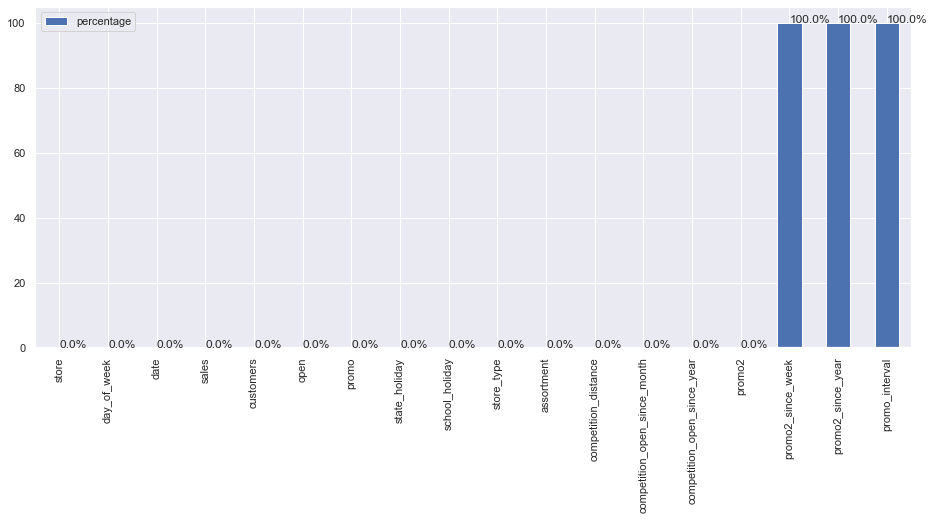

In [14]:
barchart = missing_df.plot.bar(y='percentage')
for index, percentage in enumerate( missing_percentage ):
    barchart.text( index, percentage, str(percentage)+'%')

In [15]:
#Let's drop the promo2_since_year,promo2_since_year,promo_interval
df_new_store31=df_new_store31.drop(['promo2_since_week','promo2_since_year','promo_interval'], axis = 1)

In [16]:
df_new_store31.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2'],
      dtype='object')

In [17]:
df_new_store31.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2
30,31,5,2015-07-31,7248,645,1,1,0,1,d,c,9800.0,7.0,2012.0,0
1145,31,4,2015-07-30,6712,582,1,1,0,1,d,c,9800.0,7.0,2012.0,0
2260,31,3,2015-07-29,5982,570,1,1,0,1,d,c,9800.0,7.0,2012.0,0
3375,31,2,2015-07-28,5736,492,1,1,0,1,d,c,9800.0,7.0,2012.0,0
4490,31,1,2015-07-27,8054,684,1,1,0,1,d,c,9800.0,7.0,2012.0,0


In [18]:
df_new_store31.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2
30,31,5,2015-07-31,7248,645,1,1,0,1,d,c,9800.0,7.0,2012.0,0
1145,31,4,2015-07-30,6712,582,1,1,0,1,d,c,9800.0,7.0,2012.0,0
2260,31,3,2015-07-29,5982,570,1,1,0,1,d,c,9800.0,7.0,2012.0,0
3375,31,2,2015-07-28,5736,492,1,1,0,1,d,c,9800.0,7.0,2012.0,0
4490,31,1,2015-07-27,8054,684,1,1,0,1,d,c,9800.0,7.0,2012.0,0


In [19]:
df_new_store31.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 30 to 1016125
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   store                         942 non-null    int64         
 1   day_of_week                   942 non-null    int64         
 2   date                          942 non-null    datetime64[ns]
 3   sales                         942 non-null    int64         
 4   customers                     942 non-null    int64         
 5   open                          942 non-null    int64         
 6   promo                         942 non-null    int64         
 7   state_holiday                 942 non-null    object        
 8   school_holiday                942 non-null    int64         
 9   store_type                    942 non-null    object        
 10  assortment                    942 non-null    object        
 11  competition_distance       

In [20]:
# Let's copy the dataset
df_store31 = df_new_store31.copy()

In [21]:
df_store31.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2
30,31,5,2015-07-31,7248,645,1,1,0,1,d,c,9800.0,7.0,2012.0,0
1145,31,4,2015-07-30,6712,582,1,1,0,1,d,c,9800.0,7.0,2012.0,0
2260,31,3,2015-07-29,5982,570,1,1,0,1,d,c,9800.0,7.0,2012.0,0
3375,31,2,2015-07-28,5736,492,1,1,0,1,d,c,9800.0,7.0,2012.0,0
4490,31,1,2015-07-27,8054,684,1,1,0,1,d,c,9800.0,7.0,2012.0,0


**Descriptive Statistics**

In [22]:
df_store31.describe().T

,count,mean,std,min,25%,50%,75%,max
store,942.0,31.000000,0.000000,31.0,31.00,31.0,31.0,31.0
day_of_week,942.0,3.997877,1.998404,1.0,2.00,4.0,6.0,7.0
sales,942.0,4879.132696,2506.671454,0.0,4370.25,5403.0,6316.0,13252.0
customers,942.0,487.753715,234.178009,0.0,485.00,558.0,614.0,1310.0
open,942.0,0.832272,0.373823,0.0,1.00,1.0,1.0,1.0
promo,942.0,0.382166,0.486175,0.0,0.00,0.0,1.0,1.0
school_holiday,942.0,0.168790,0.374765,0.0,0.00,0.0,0.0,1.0
competition_distance,942.0,9800.000000,0.000000,9800.0,9800.00,9800.0,9800.0,9800.0
competition_open_since_month,942.0,7.000000,0.000000,7.0,7.00,7.0,7.0,7.0
competition_open_since_year,942.0,2012.000000,0.000000,2012.0,2012.00,2012.0,2012.0,2012.0


In [24]:
# separate numerical and categorical attributes
num_attributes = df_store31.select_dtypes( include = 'number')
cate_attributes = df_store31.select_dtypes( include = 'object')

**Numerical Attributes**

In [25]:
# Central Tendency - Mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtoisis
d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply( min )).T
d3 = pd.DataFrame(num_attributes.apply( max )).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()


m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,31.0,31.0,0.0,31.000000,31.0,0.000000,0.000000,0.000000
1,day_of_week,1.0,7.0,6.0,3.997877,4.0,1.997343,0.002127,-1.247185
2,sales,0.0,13252.0,13252.0,4879.132696,5403.0,2505.340596,-0.757594,0.286002
3,customers,0.0,1310.0,1310.0,487.753715,558.0,234.053678,-1.222017,0.651901
4,open,0.0,1.0,1.0,0.832272,1.0,0.373625,-1.781477,1.176152
5,promo,0.0,1.0,1.0,0.382166,0.0,0.485917,0.485772,-1.767783
6,school_holiday,0.0,1.0,1.0,0.168790,0.0,0.374566,1.771322,1.139998
7,competition_distance,9800.0,9800.0,0.0,9800.000000,9800.0,0.000000,0.000000,0.000000
8,competition_open_since_month,7.0,7.0,0.0,7.000000,7.0,0.000000,0.000000,0.000000
9,competition_open_since_year,2012.0,2012.0,0.0,2012.000000,2012.0,0.000000,0.000000,0.000000


**Categorical Attributes**


In [26]:
# check unique values of categorical features
cate_attributes.apply( lambda x: x.unique().shape[0])

state_holiday    5
store_type       1
assortment       1
dtype: int64

In [28]:
#Let's check the unique values
print(df_store31['state_holiday'].unique())
print(df_store31['store_type'].unique())
print(df_store31['assortment'].unique())

['0' 'a' 'b' 'c' 0]
['d']
['c']


In [29]:
df_store31.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2'],
      dtype='object')

# Exploratory data analysis(EDA)

Let’s perform EDA to gain insights into the given data.

**Univariate Analysis**

Response Variable (target)

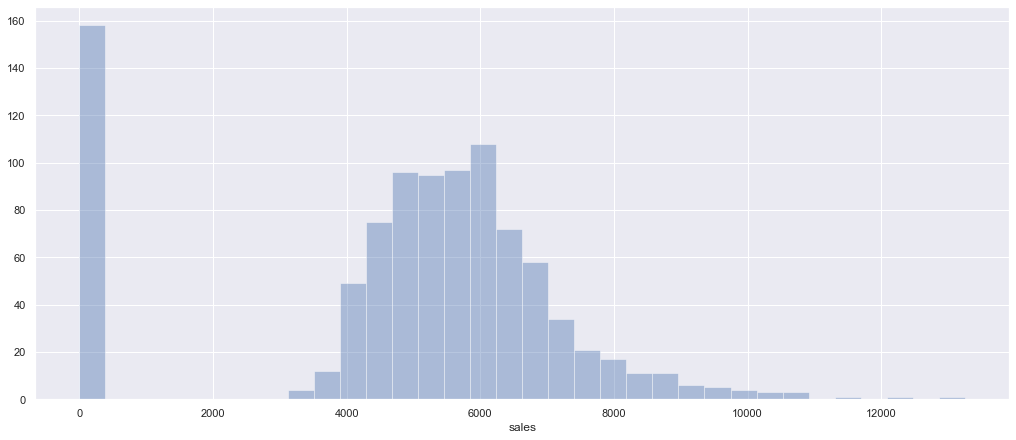

In [31]:
fig = plt.figure( figsize = (14, 6), constrained_layout=True)
sns.distplot(df_store31['sales'], kde = False);
plt.show()

**Numerical Variable**

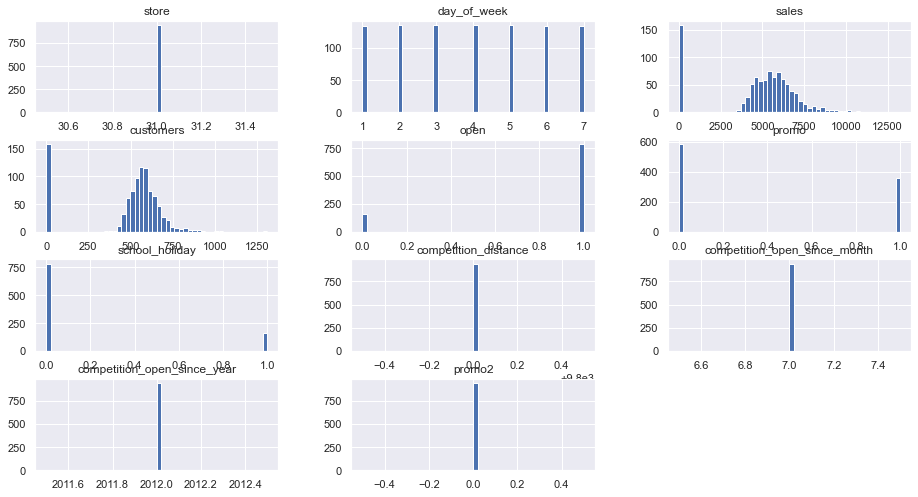

In [32]:
sns.set(rc={'figure.figsize':(15.7,8.27)})
num_attributes.hist(bins = 50);

In [34]:
df_store31['day_of_week'].value_counts()
#day of the week

5    135
4    135
3    135
2    135
7    134
6    134
1    134
Name: day_of_week, dtype: int64

In [35]:
df_store31['open'].value_counts()
# value count of store is open or not

1    784
0    158
Name: open, dtype: int64

In [36]:
df_store31['school_holiday'].value_counts()
# value count of state_holiday

0    783
1    159
Name: school_holiday, dtype: int64

In [37]:
df_store31['store_type'].value_counts()
# value count of Store_type

d    942
Name: store_type, dtype: int64

In [40]:
df_store31['assortment'].value_counts()
# value count of assortment

c    942
Name: assortment, dtype: int64

In [42]:
df_store31['competition_distance'].value_counts()
# value count of competition distance

9800.0    942
Name: competition_distance, dtype: int64

In [43]:
df_store31['competition_open_since_month'].value_counts()
# value count of competition distance

7.0    942
Name: competition_open_since_month, dtype: int64

In [45]:
df_store31['competition_open_since_year'].value_counts()
# value count of competition open since year

2012.0    942
Name: competition_open_since_year, dtype: int64

In [46]:
df_store31['promo2'].value_counts()
# value count of promo2

0    942
Name: promo2, dtype: int64

In [39]:
df_store31.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2'],
      dtype='object')

**Categorical Variable**

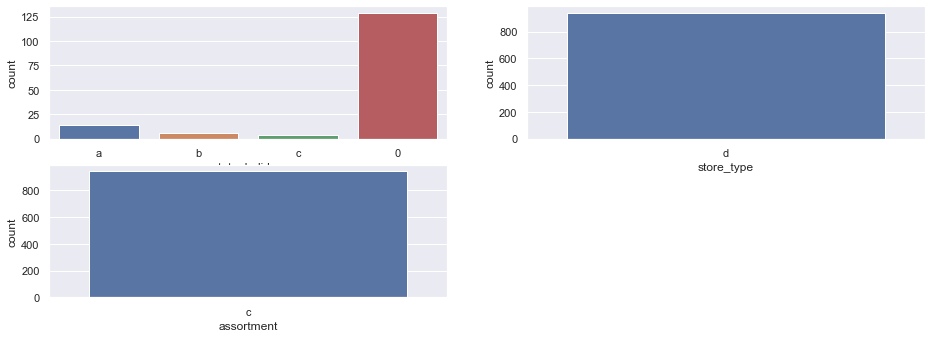

In [47]:
# state_holiday
plt.subplot(3, 2, 1)
a = df_store31[df_store31['state_holiday'] != '0']
sns.countplot(data = a, x = a['state_holiday'])

# store_type
plt.subplot(3, 2, 2)
sns.countplot(data = df_store31, x = df_store31['store_type'])

# assortment
plt.subplot(3, 2, 3)
sns.countplot(data = df_store31, x = df_store31['assortment'])

plt.show()

In [49]:
# Zero values in sales 
df_store31[df_store31['sales']==0]

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2
5605,31,7,2015-07-26,0,0,0,0,0,0,d,c,9800.0,7.0,2012.0,0
13410,31,7,2015-07-19,0,0,0,0,0,0,d,c,9800.0,7.0,2012.0,0
21215,31,7,2015-07-12,0,0,0,0,0,0,d,c,9800.0,7.0,2012.0,0
29020,31,7,2015-07-05,0,0,0,0,0,0,d,c,9800.0,7.0,2012.0,0
36825,31,7,2015-06-28,0,0,0,0,0,0,d,c,9800.0,7.0,2012.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987135,31,7,2013-01-27,0,0,0,0,0,0,d,c,9800.0,7.0,2012.0,0
994940,31,7,2013-01-20,0,0,0,0,0,0,d,c,9800.0,7.0,2012.0,0
1002745,31,7,2013-01-13,0,0,0,0,0,0,d,c,9800.0,7.0,2012.0,0
1010550,31,7,2013-01-06,0,0,0,0,0,0,d,c,9800.0,7.0,2012.0,0


In [50]:
df_store31.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 30 to 1016125
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   store                         942 non-null    int64         
 1   day_of_week                   942 non-null    int64         
 2   date                          942 non-null    datetime64[ns]
 3   sales                         942 non-null    int64         
 4   customers                     942 non-null    int64         
 5   open                          942 non-null    int64         
 6   promo                         942 non-null    int64         
 7   state_holiday                 942 non-null    object        
 8   school_holiday                942 non-null    int64         
 9   store_type                    942 non-null    object        
 10  assortment                    942 non-null    object        
 11  competition_distance       


-    Sale  and customer colomns has zero values which has to be imputed

-    Store is open on 80% of days

-    80% are regular days

-    All the rows of column-store type belongs to 'd'

-    All the rows of column-assortment belongs to 'c'

-    All the rows of columns-competition_distance to 9800

-    All the rows of promo2 belogs to 0

**Bivariate Analysis**

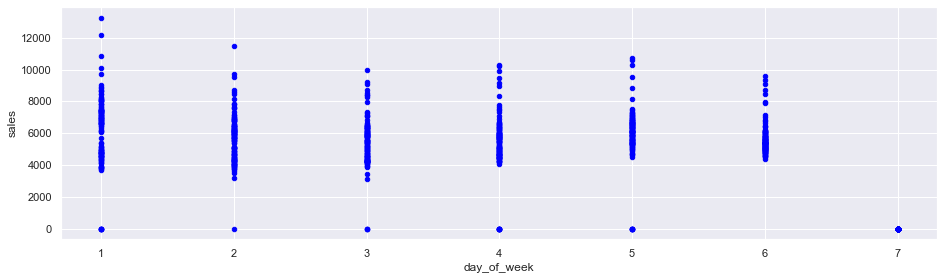

In [51]:
# lets draw a scatter plot between  Sales and day_of_week
sns.set(rc={'figure.figsize':(15.7,4.27)})
df_store31[['sales', 'day_of_week']].plot.scatter(x = 'day_of_week',y='sales',c='blue')
plt.show()

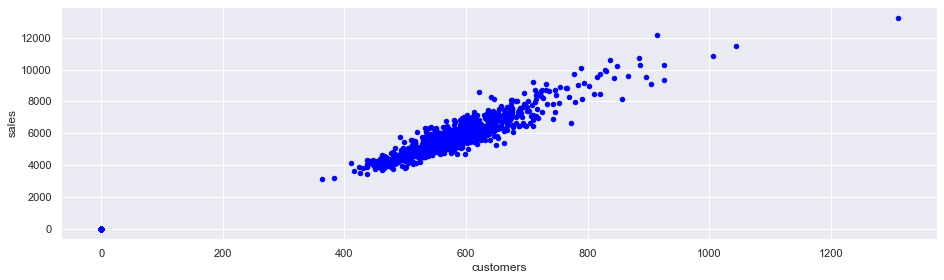

In [52]:
#Let's draw a scatter plot between Sales and Customers
df_store31[['sales', 'customers']].plot.scatter(x = 'customers',y='sales',c='blue')
plt.show()

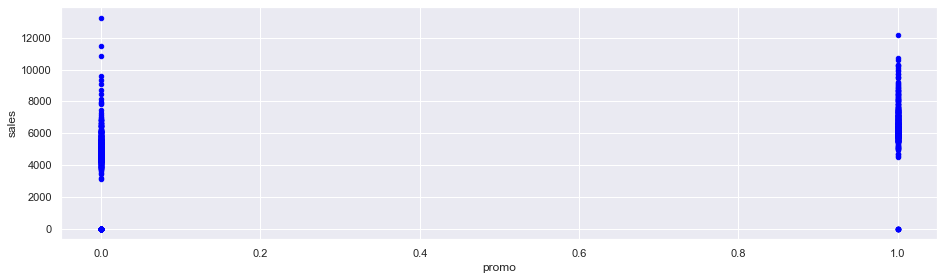

In [53]:
#Let's now draw a scatter plot between Sales and promo
df_store31[['sales', 'promo']].plot.scatter(x = 'promo',y='sales',c='blue')
plt.show()

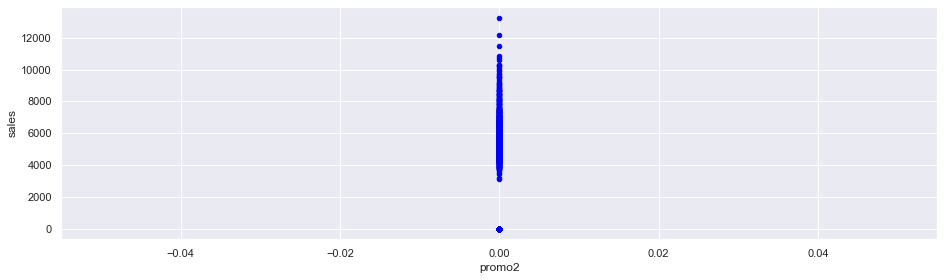

In [54]:
#Let's now draw a scatter plot between Sales and promo
df_store31[['sales', 'promo2']].plot.scatter(x = 'promo2',y='sales',c='blue')
plt.show()

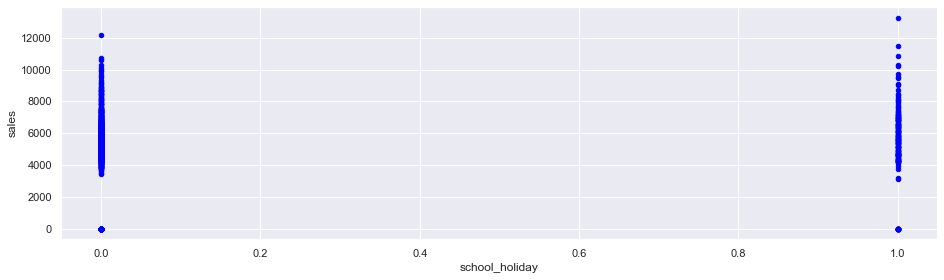

In [55]:
#lets now draw a scatter plot between  Sales and school_holiday
df_store31[['sales', 'school_holiday']].plot.scatter(x = 'school_holiday',y='sales',c='blue')
plt.show()

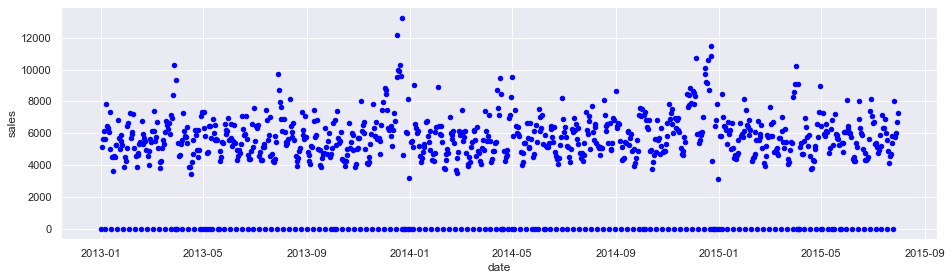

In [56]:
#lets now draw a scatter plot between Sales and date
df_store31[['sales', 'date']].plot.scatter(x = 'date',y='sales',c='blue')
plt.show()

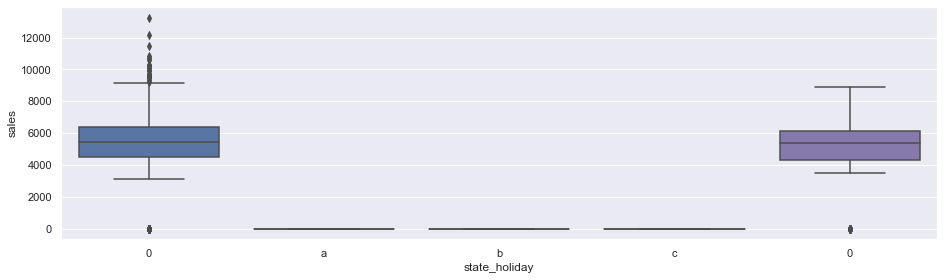

In [57]:
#Let's draw the boxplot between sales and state_holiday
sns.set(rc={'figure.figsize':(15.7,4.27)})
# create grouped boxplot 
sns.boxplot(x = df_store31['state_holiday'],
            y = df_store31['sales'])
plt.show()

**Multivariate Analysis**

**Numerical Attributes**

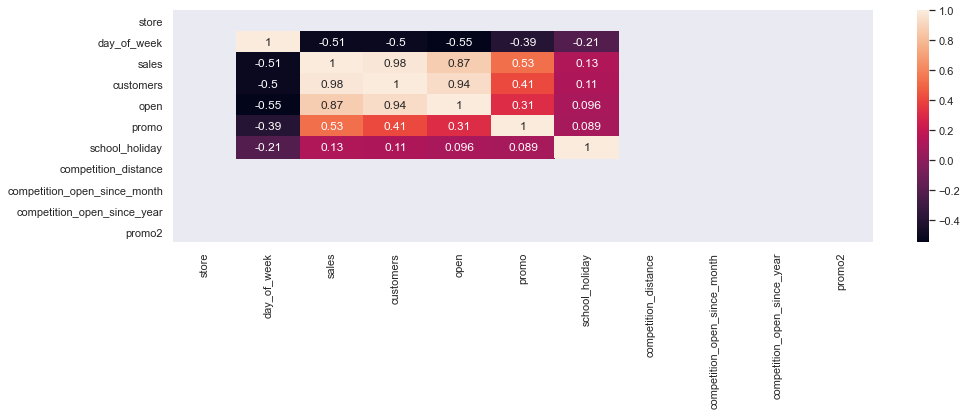

In [58]:
correlation = (num_attributes.corr( method = 'pearson' ))
sns.heatmap( correlation, annot = True );

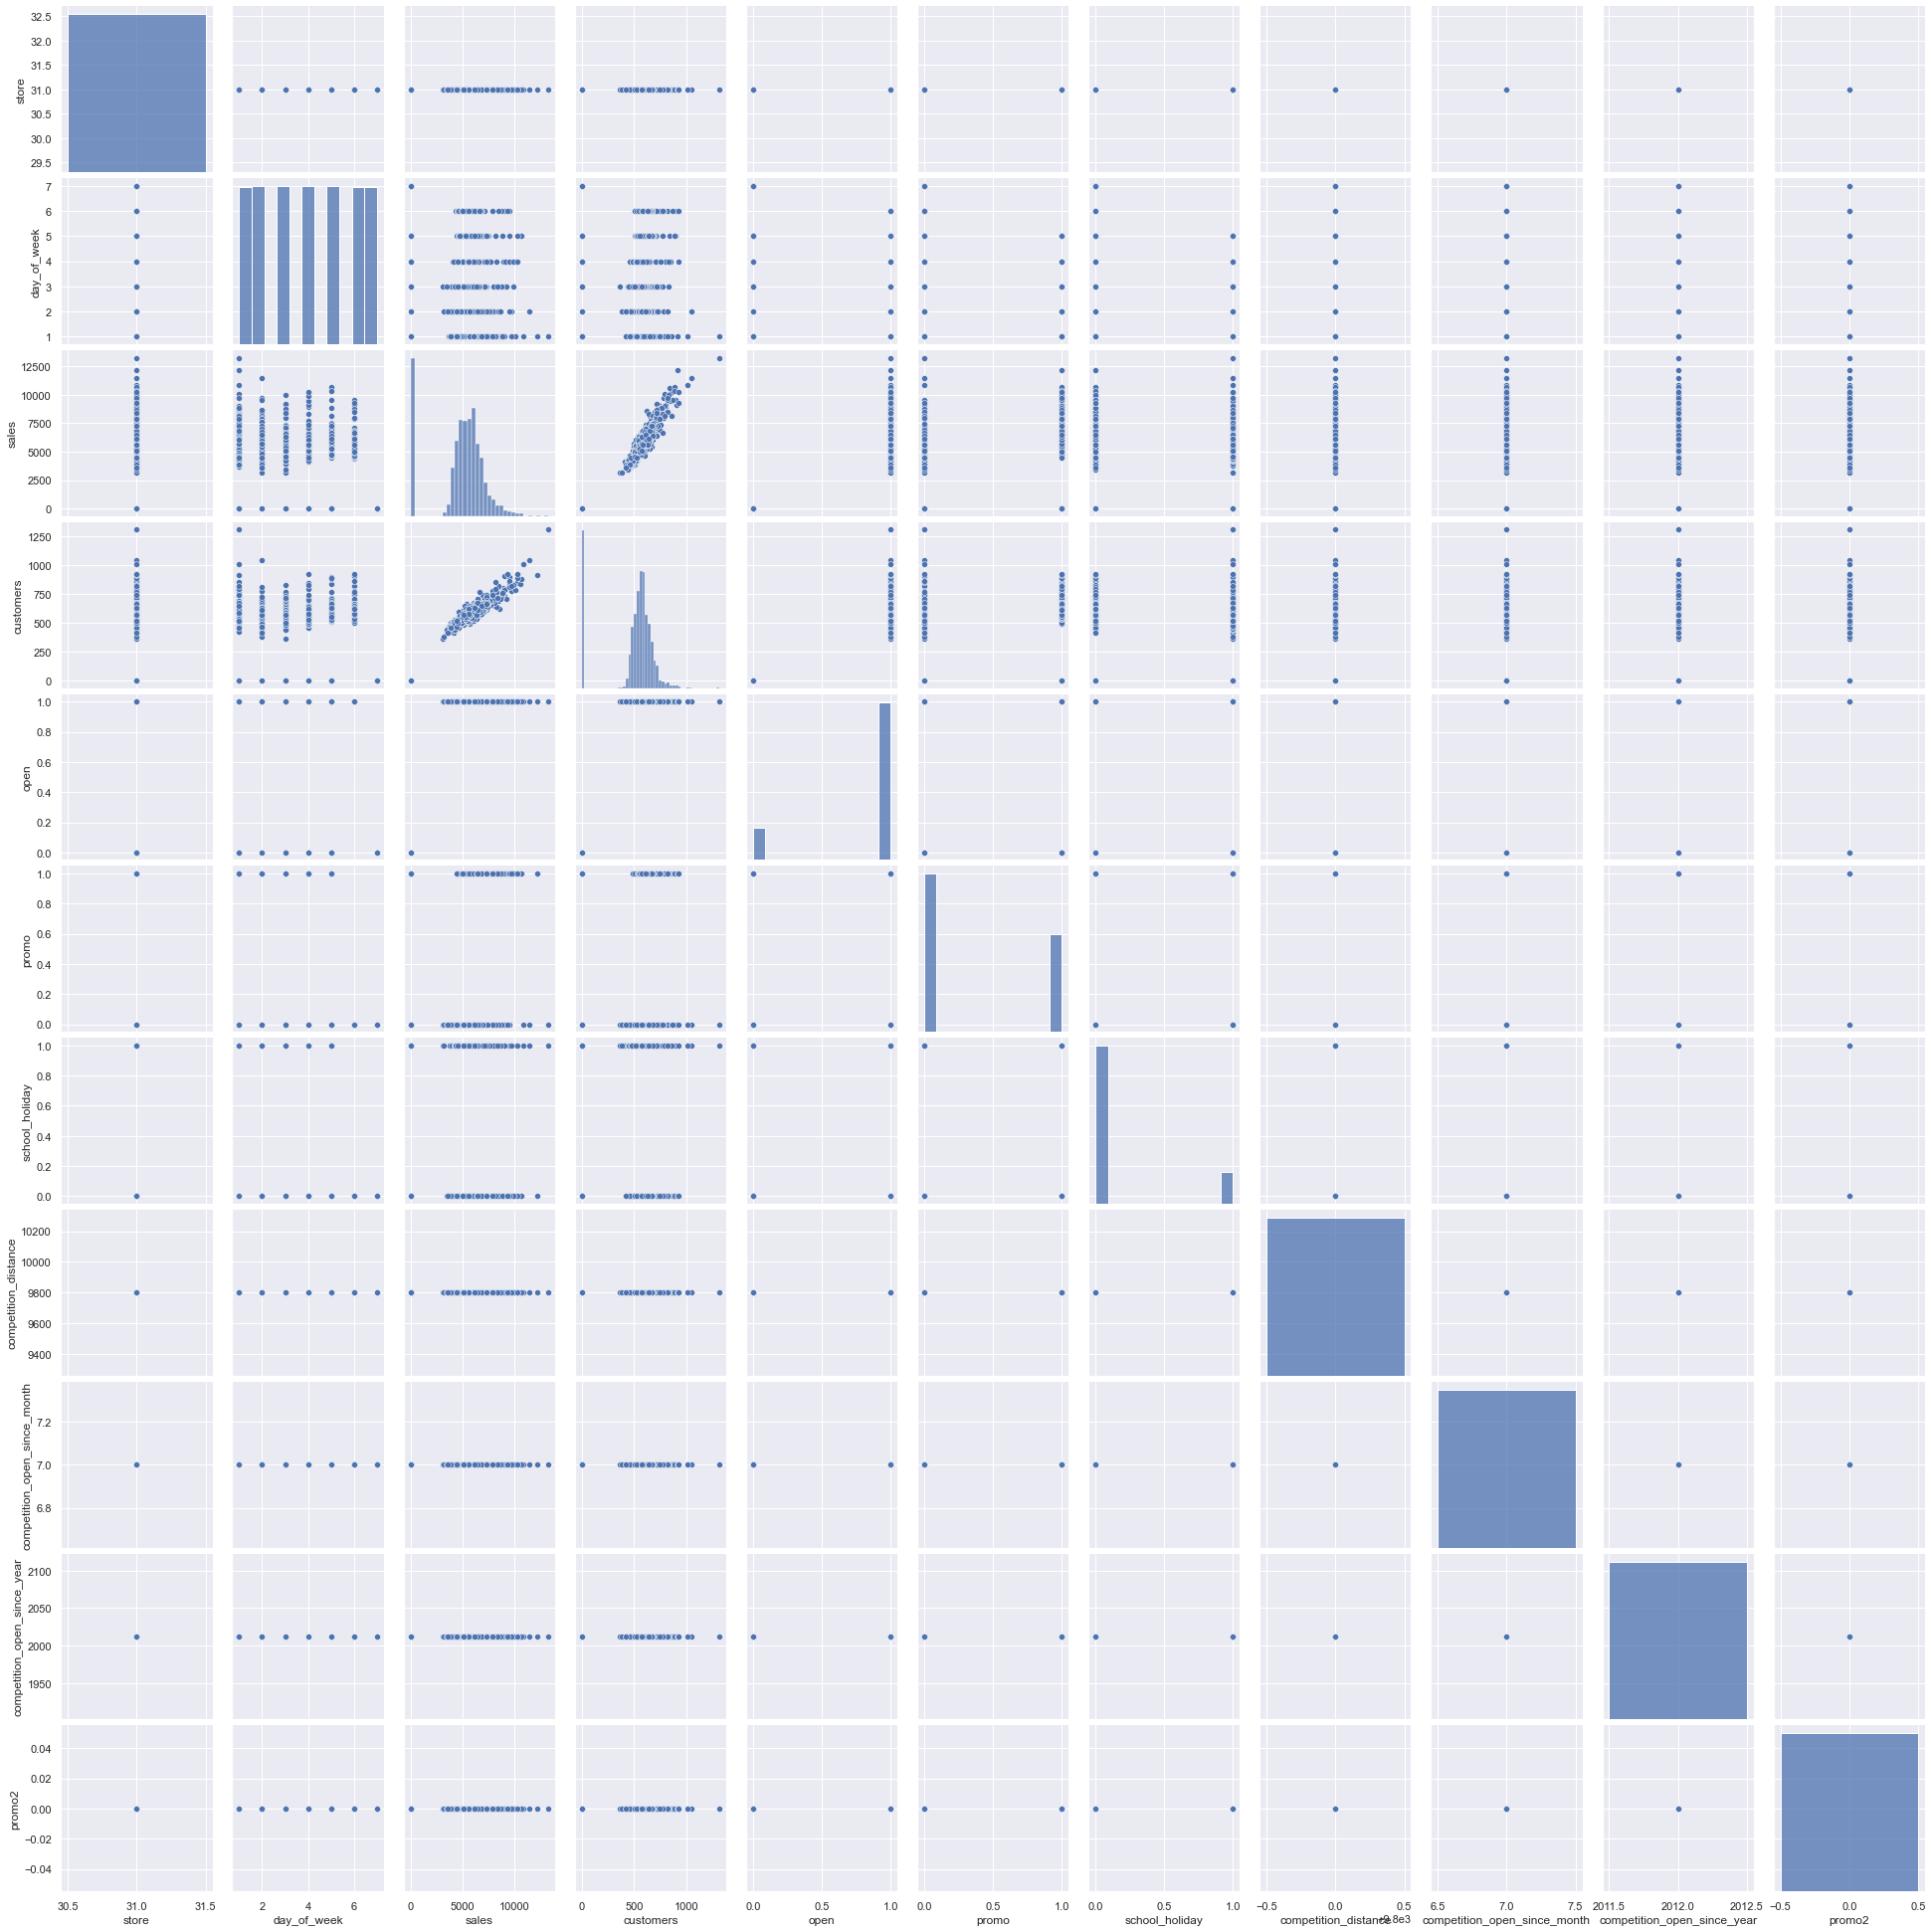

In [59]:
#pairplot with hue sales
sns.pairplot(df_store31)
# to show
plt.show()

**Some insights from EDA**

   - store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year are uncessary columns becuase it doesn't have any effect on sales(target variable)

   - Day1 and Day2 have higher sales than other days

   - promo is correlated to sales

   - Promo2 doesn't have any effect on sales becuase it's value is equal to 1

   - There is no sale on a = public holiday, b = Easter holiday, c = Christmas

   - There is some effect of school holiday on sales

In [60]:
df_store31.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2'],
      dtype='object')

In [61]:
#We can drop store_type,assortment,competition_distance,competition_open_since_month,promo2_since_week,promo2_since_year,promo_interval
#competition_open_since_year & promo2
df_store31_new=df_store31.drop(['store_type', 'assortment','competition_distance','competition_open_since_month','competition_open_since_year'], axis = 1)
df_store31_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 30 to 1016125
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   store           942 non-null    int64         
 1   day_of_week     942 non-null    int64         
 2   date            942 non-null    datetime64[ns]
 3   sales           942 non-null    int64         
 4   customers       942 non-null    int64         
 5   open            942 non-null    int64         
 6   promo           942 non-null    int64         
 7   state_holiday   942 non-null    object        
 8   school_holiday  942 non-null    int64         
 9   promo2          942 non-null    int64         
dtypes: datetime64[ns](1), int64(8), object(1)
memory usage: 121.0+ KB


In [62]:
df_store31_new.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'promo2'],
      dtype='object')

In [63]:
df_store31_new.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,promo2
30,31,5,2015-07-31,7248,645,1,1,0,1,0
1145,31,4,2015-07-30,6712,582,1,1,0,1,0
2260,31,3,2015-07-29,5982,570,1,1,0,1,0
3375,31,2,2015-07-28,5736,492,1,1,0,1,0
4490,31,1,2015-07-27,8054,684,1,1,0,1,0


In [64]:
# saving the dataframe
#df_store31_new.to_csv('cleaned_df_store31.csv')

# Model Building

**ARIMA model**

In [65]:
path = "cleaned_df_store31.csv"
df_store31_new = pd.read_csv(path)
df_store31_new.head()
#Let load the data

,Unnamed: 0,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,promo2
0,30,31,5,2015-07-31,7248,645,1,1,0,1,0
1,1145,31,4,2015-07-30,6712,582,1,1,0,1,0
2,2260,31,3,2015-07-29,5982,570,1,1,0,1,0
3,3375,31,2,2015-07-28,5736,492,1,1,0,1,0
4,4490,31,1,2015-07-27,8054,684,1,1,0,1,0


In [66]:
df_store31_new=df_store31_new[::-1].reset_index()
df_store31_new.head()

,index,Unnamed: 0,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,promo2
0,941,1016125,31,2,2013-01-01,0,0,0,0,a,1,0
1,940,1015010,31,3,2013-01-02,5122,567,1,0,0,1,0
2,939,1013895,31,4,2013-01-03,5623,578,1,0,0,1,0
3,938,1012780,31,5,2013-01-04,6140,633,1,0,0,1,0
4,937,1011665,31,6,2013-01-05,5607,624,1,0,0,0,0


In [67]:
df_store31_new=df_store31_new.drop(['Unnamed: 0'], axis = 1)
df_store31_new=df_store31_new.drop(['index'], axis = 1)
df_store31_new.head()
#Let drop the Unnamed: 0 column

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,promo2
0,31,2,2013-01-01,0,0,0,0,a,1,0
1,31,3,2013-01-02,5122,567,1,0,0,1,0
2,31,4,2013-01-03,5623,578,1,0,0,1,0
3,31,5,2013-01-04,6140,633,1,0,0,1,0
4,31,6,2013-01-05,5607,624,1,0,0,0,0


In [68]:
df_store31_new.info()
#No missing value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942 entries, 0 to 941
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   store           942 non-null    int64 
 1   day_of_week     942 non-null    int64 
 2   date            942 non-null    object
 3   sales           942 non-null    int64 
 4   customers       942 non-null    int64 
 5   open            942 non-null    int64 
 6   promo           942 non-null    int64 
 7   state_holiday   942 non-null    object
 8   school_holiday  942 non-null    int64 
 9   promo2          942 non-null    int64 
dtypes: int64(8), object(2)
memory usage: 73.7+ KB


In [69]:
# transform datatype of the variable data to datetime
df_store31_new['date'] = pd.to_datetime(df_store31_new['date'])

In [70]:
indexed_df_store31_new = df_store31_new.set_index(['date'])
indexed_df_store31_new.head()
#Let set the date as index column

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2
date,,,,,,,,,
2013-01-01,31,2,0,0,0,0,a,1,0
2013-01-02,31,3,5122,567,1,0,0,1,0
2013-01-03,31,4,5623,578,1,0,0,1,0
2013-01-04,31,5,6140,633,1,0,0,1,0
2013-01-05,31,6,5607,624,1,0,0,0,0


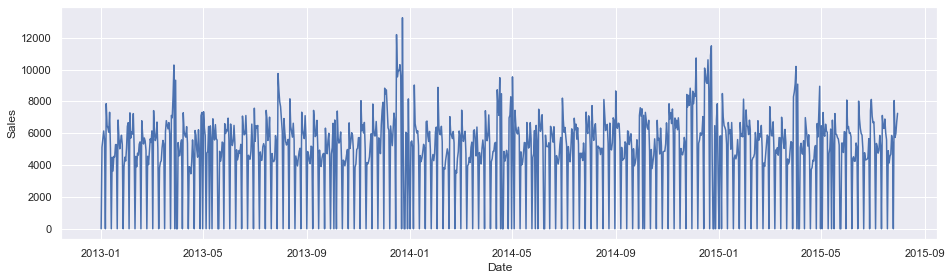

In [71]:
## plot graph
plt.xlabel('Date')
plt.ylabel('Sales')
plt.plot(indexed_df_store31_new['sales'])
plt.show()

In [73]:
#Let impute the zero values
(indexed_df_store31_new['sales']==0).sum()
# There are 158 zero value in sale column

158

In [74]:
indexed_df_store31_new['sales']=indexed_df_store31_new['sales'].replace(0, np.nan)

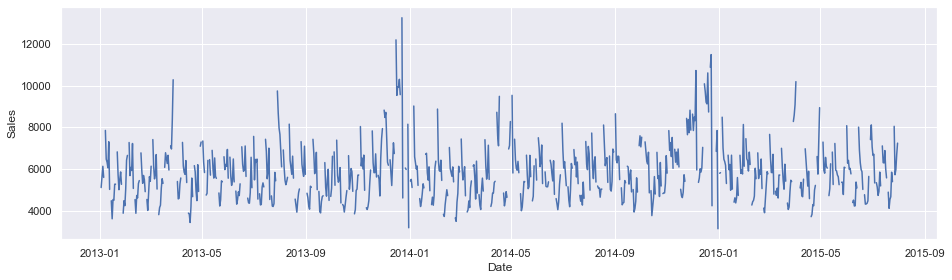

In [75]:
##plot graph
plt.xlabel('Date')
plt.ylabel('Sales')
plt.plot(indexed_df_store31_new['sales'])
plt.show()

In [76]:
#KNN imputer for filling NAN values
imputer = KNNImputer(n_neighbors=2)

In [77]:
indexed_df_store31_new['sales'] = imputer.fit_transform(np.array(indexed_df_store31_new['sales']).reshape(-1, 1))
indexed_df_store31_new['sales'].head()

date
2013-01-01    5862.427296
2013-01-02    5122.000000
2013-01-03    5623.000000
2013-01-04    6140.000000
2013-01-05    5607.000000
Name: sales, dtype: float64

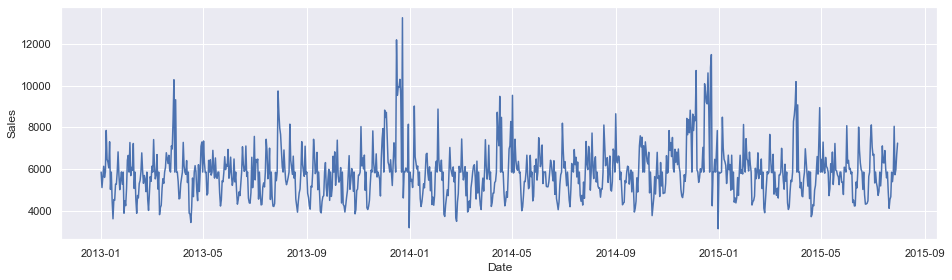

In [78]:
## plot graph
plt.xlabel('Date')
plt.ylabel('Sales')
plt.plot(indexed_df_store31_new['sales'])
plt.show()

In [79]:
(indexed_df_store31_new['sales']==0).sum()
# no missing value

0

**Outlier detection**

Box plot and interquartile range

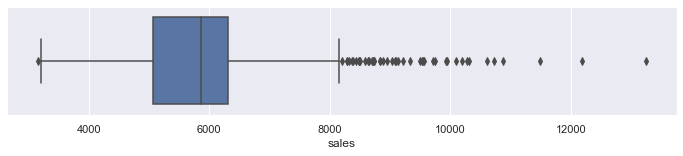

In [80]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=indexed_df_store31_new['sales'],whis=1.5)
#Let treat the outliers

**Histogram**

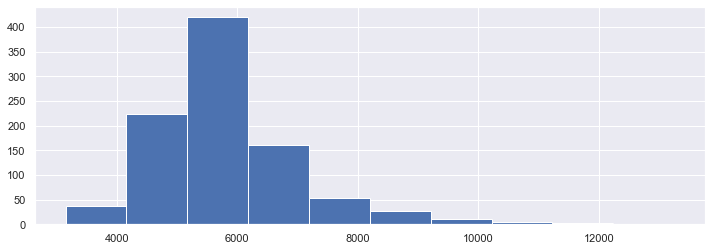

In [81]:
fig = indexed_df_store31_new['sales'].hist(figsize = (12,4))

In [82]:
percentile01 = indexed_df_store31_new['sales'].quantile(0.01)
percentile99 = indexed_df_store31_new['sales'].quantile(0.99)

In [83]:
upper_limit = percentile99
lower_limit = percentile01

In [84]:
upper_limit

10030.550000000005

In [85]:
lower_limit

3831.15

In [86]:
new_df = indexed_df_store31_new[indexed_df_store31_new['sales'] < upper_limit]
new_df.shape

(932, 9)

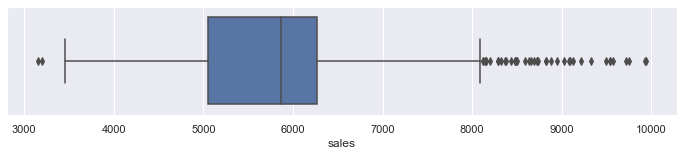

In [87]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=new_df['sales'],whis=1.5)

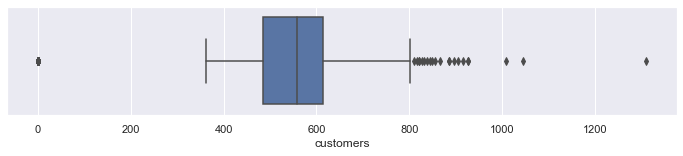

In [89]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=indexed_df_store31_new['customers'],whis=1.5)

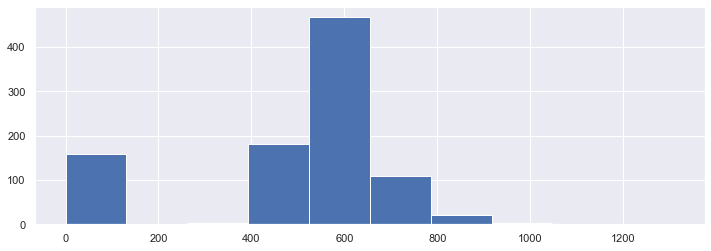

In [90]:
fig = indexed_df_store31_new['customers'].hist(figsize = (12,4))

**ADF Stationary**

In [91]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(indexed_df_store31_new['sales'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

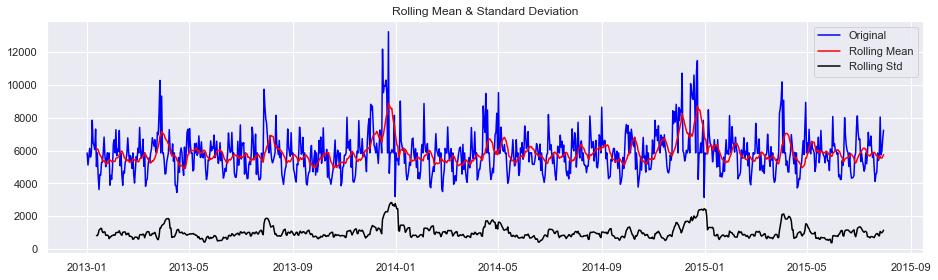

Results of Dickey Fuller Test:
Test Statistic                  -5.305838
p-value                          0.000005
#Lags Used                      17.000000
Number of Observations Used    924.000000
Critical Value (1%)             -3.437447
Critical Value (5%)             -2.864673
Critical Value (10%)            -2.568438
dtype: float64


In [92]:
test_stationarity(indexed_df_store31_new['sales'])

- Null: Time Series is not stationary
- Alternate: Time Series is Stationary

**The p-value is less than 0.05 so The series is stationary**

In [95]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(indexed_df_store31_new['sales'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.211425
Critical Values @ 0.05: 0.46
p-value: 0.100000


- Null: Time Series is not stationary
- Alternate: Time Series is Stationary
    
**The p-value is greater than 0.05 so The series is stationary**

# Let's take the log of sales to Standardize the sales values

In [97]:
new_df=indexed_df_store31_new.copy()
new_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 942 entries, 2013-01-01 to 2015-07-31
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   store           942 non-null    int64  
 1   day_of_week     942 non-null    int64  
 2   sales           942 non-null    float64
 3   customers       942 non-null    int64  
 4   open            942 non-null    int64  
 5   promo           942 non-null    int64  
 6   state_holiday   942 non-null    object 
 7   school_holiday  942 non-null    int64  
 8   promo2          942 non-null    int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 73.6+ KB


In [98]:
#Log Transformation
new_df['sales_log'] = np.log(new_df['sales'])
new_df.head()

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2,sales_log
date,,,,,,,,,,
2013-01-01,31,2,5862.427296,0,0,0,a,1,0,8.676319
2013-01-02,31,3,5122.000000,567,1,0,0,1,0,8.541300
2013-01-03,31,4,5623.000000,578,1,0,0,1,0,8.634621
2013-01-04,31,5,6140.000000,633,1,0,0,1,0,8.722580
2013-01-05,31,6,5607.000000,624,1,0,0,0,0,8.631771


**Log transformation has made mean & variance constant**

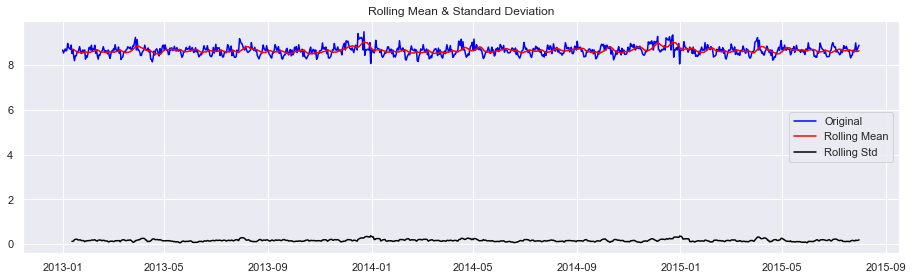

Results of Dickey Fuller Test:
Test Statistic                  -5.305838
p-value                          0.000005
#Lags Used                      17.000000
Number of Observations Used    924.000000
Critical Value (1%)             -3.437447
Critical Value (5%)             -2.864673
Critical Value (10%)            -2.568438
dtype: float64


In [99]:
test_stationarity(new_df['sales_log'])

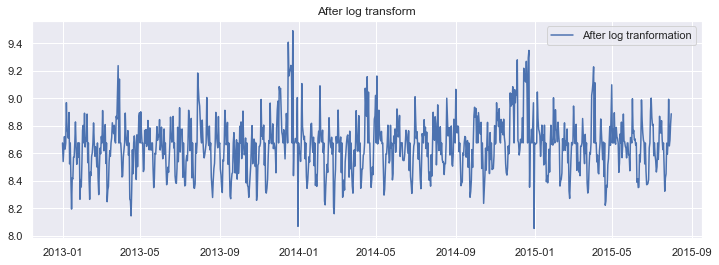

In [100]:
#After Log Transformation
plt.figure(figsize=(12,4))
plt.plot(new_df['sales_log'], label='After log tranformation')
plt.legend(loc='best')
plt.title('After log transform')
plt.show()

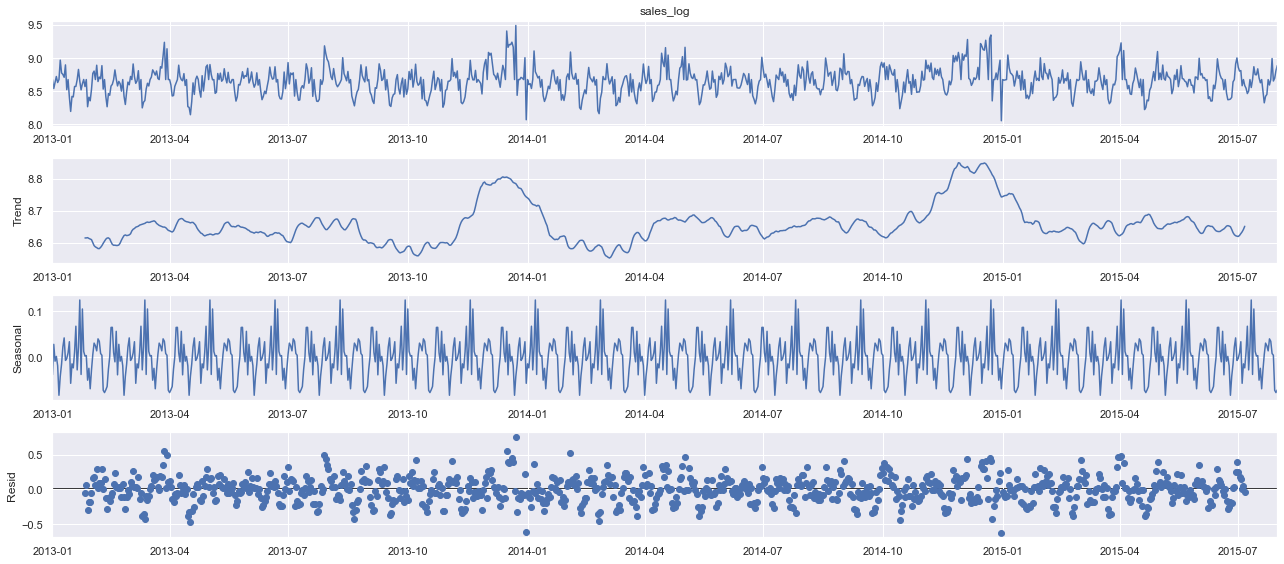

In [101]:
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 18,8
decomposition = sm.tsa.seasonal_decompose(new_df['sales_log'], model = "additive",period=50)
fig = decomposition.plot()

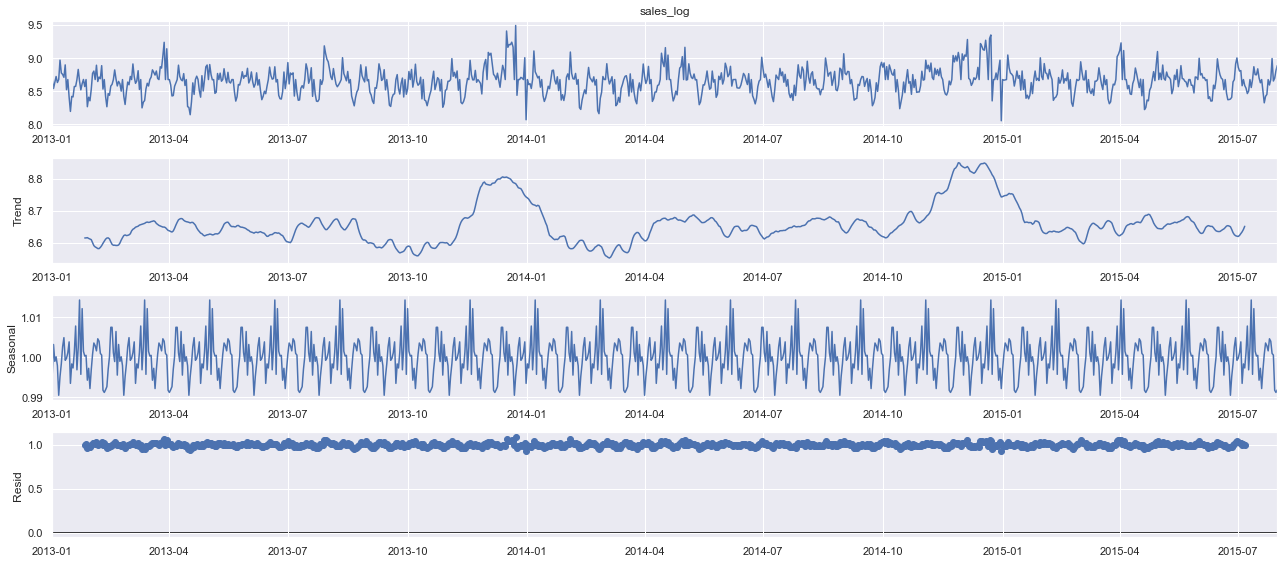

In [102]:
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 18,8
decomposition = sm.tsa.seasonal_decompose(new_df['sales_log'], model = "multiplicative",period=50)
fig = decomposition.plot()

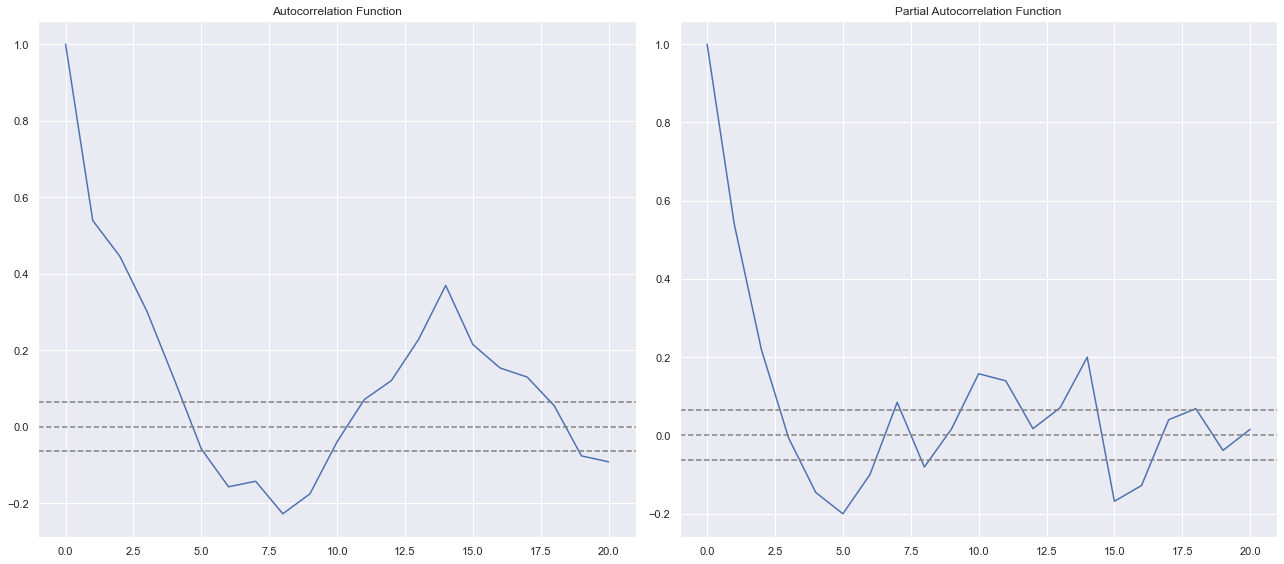

In [103]:
#ACF & PACF plots

lag_acf = acf(new_df['sales_log'], nlags=20) # MA 
lag_pacf = pacf(new_df['sales_log'], nlags=20, method='ols')  # AR 

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(new_df['sales_log'])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(new_df['sales_log'])), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(new_df['sales_log'])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(new_df['sales_log'])), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout() 

From the ACF graph, we see that curve touches y=0.0 line at x=4. Thus, from theory, Q = 4 From the PACF graph, we see that curve touches y=0.0 line at x=3. Thus, from theory, P = 3

**Build and evaluate time series forecast**

Split time series data into training and test set


In [104]:
train_len = 750
train = new_df['sales'][0:train_len] # first 750days as training set
test = new_df['sales'][train_len:] # last 182 days as out-of-time test set

In [105]:
print(train.shape)
print(test.shape)

(750,)
(192,)


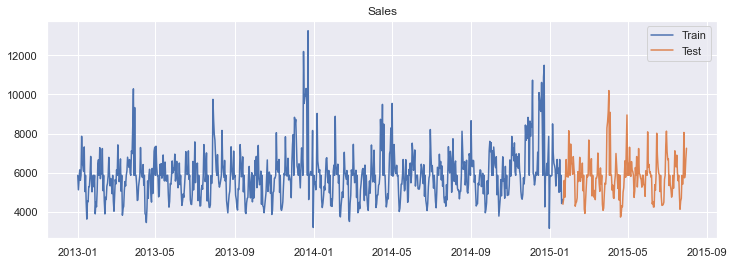

In [106]:
plt.figure(figsize=(12,4))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.legend(loc='best')
plt.title('Sales')
plt.show()

In [107]:
model = ARIMA(new_df['sales_log'], order=(3, 0, 4))
model_fit = model.fit()
print(model_fit.params)

const              8.656665
ar.L1.sales_log    0.678037
ar.L2.sales_log    0.780713
ar.L3.sales_log   -0.842180
ma.L1.sales_log   -0.322014
ma.L2.sales_log   -0.681140
ma.L3.sales_log    0.639017
ma.L4.sales_log    0.070642
dtype: float64


In [108]:
new_df['ar_forecast_Log'] = model_fit.predict(new_df.index.min(), new_df.index.max())
new_df['arima_forecast'] = np.exp(new_df['ar_forecast_Log'])
new_df['arima_forecast']

date
2013-01-01    5748.331141
2013-01-02    5809.086369
2013-01-03    5491.219931
2013-01-04    5560.027497
2013-01-05    5845.552293
                 ...     
2015-07-27    6222.729793
2015-07-28    7045.304065
2015-07-29    6595.419089
2015-07-30    6214.863684
2015-07-31    6143.948883
Name: arima_forecast, Length: 942, dtype: float64

In [109]:
new_df['ar_forecast_Log'] = model_fit.predict(new_df.index.min(), new_df.index.max())
new_df['arima_forecast'] = np.exp(new_df['ar_forecast_Log'])
new_df['arima_forecast']

date
2013-01-01    5748.331141
2013-01-02    5809.086369
2013-01-03    5491.219931
2013-01-04    5560.027497
2013-01-05    5845.552293
                 ...     
2015-07-27    6222.729793
2015-07-28    7045.304065
2015-07-29    6595.419089
2015-07-30    6214.863684
2015-07-31    6143.948883
Name: arima_forecast, Length: 942, dtype: float64

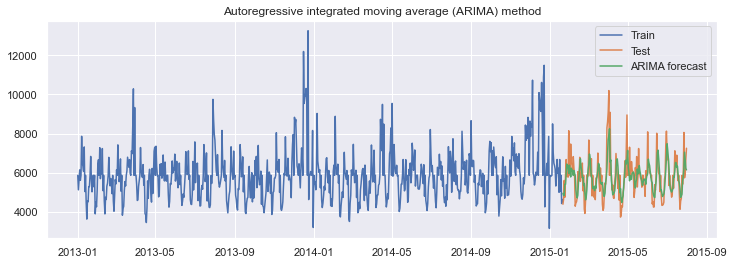

In [110]:
plt.figure(figsize=(12,4))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(new_df['arima_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('Autoregressive integrated moving average (ARIMA) method')
plt.show()

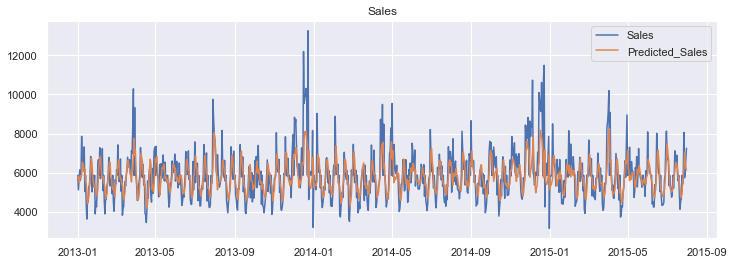

In [111]:
# plot the arima forecasting & Original series
plt.figure(figsize=(12,4))
plt.plot(new_df['sales'], label='Sales')
plt.plot(new_df['arima_forecast'], label='Predicted_Sales')
plt.legend(loc='best')
plt.title('Sales')
plt.show()

**Model Evalution**


In [112]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test, new_df['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test-new_df['arima_forecast'][test.index.min():])/test)*100,2)
Results = pd.DataFrame({'Method':['ARIMA'], 'RMSE': [rmse],'MAPE': [mape] })
Results

,Method,RMSE,MAPE
0,ARIMA,804.7,10.32


**VAR model**

In [113]:
#Load the dataset
new_df.head()

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast
date,,,,,,,,,,,,
2013-01-01,31,2,5862.427296,0,0,0,a,1,0,8.676319,8.656665,5748.331141
2013-01-02,31,3,5122.000000,567,1,0,0,1,0,8.541300,8.667179,5809.086369
2013-01-03,31,4,5623.000000,578,1,0,0,1,0,8.634621,8.610906,5491.219931
2013-01-04,31,5,6140.000000,633,1,0,0,1,0,8.722580,8.623358,5560.027497
2013-01-05,31,6,5607.000000,624,1,0,0,0,0,8.631771,8.673436,5845.552293


**Split the dataset to training & testing**

In [114]:
#split the dataset
nobs = 192
train, test = new_df[0:-nobs], new_df[-nobs:]

# Check size
print(train.shape)
print(test.shape)  

(750, 12)
(192, 12)


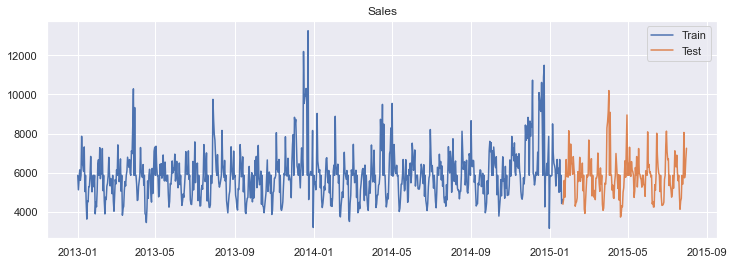

In [115]:
plt.figure(figsize=(12,4))
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.legend(loc='best')
plt.title('Sales')
plt.show()

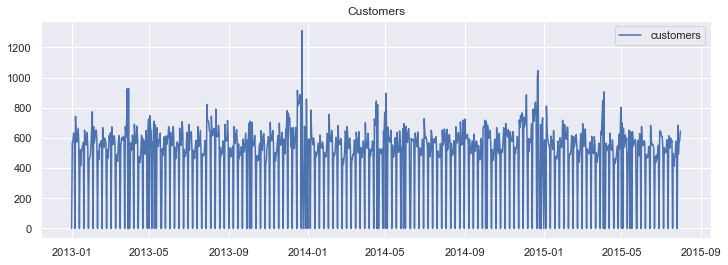

In [116]:
#plot the arima forecasting & Original series
plt.figure(figsize=(12,4))
plt.plot(new_df['customers'],label='customers')
plt.legend(loc='best')
plt.title('Customers')
plt.show()

In [117]:
(new_df['customers']==0).sum()

158

In [118]:
#impute the NAN values
new_df['customers']=new_df['customers'].replace(0, np.nan)

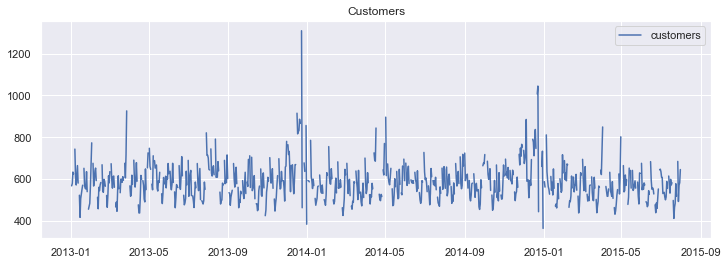

In [119]:
#plot the arima forecasting & Original series
plt.figure(figsize=(12,4))
plt.plot(new_df['customers'],label='customers')
plt.legend(loc='best')
plt.title('Customers')
plt.show()

In [120]:
#KNN imputer for filling NAN values
imputer = KNNImputer(n_neighbors=2)

In [121]:
new_df['customers'] = imputer.fit_transform(np.array(new_df['customers']).reshape(-1, 1))
new_df['customers'].head()

date
2013-01-01    586.05102
2013-01-02    567.00000
2013-01-03    578.00000
2013-01-04    633.00000
2013-01-05    624.00000
Name: customers, dtype: float64

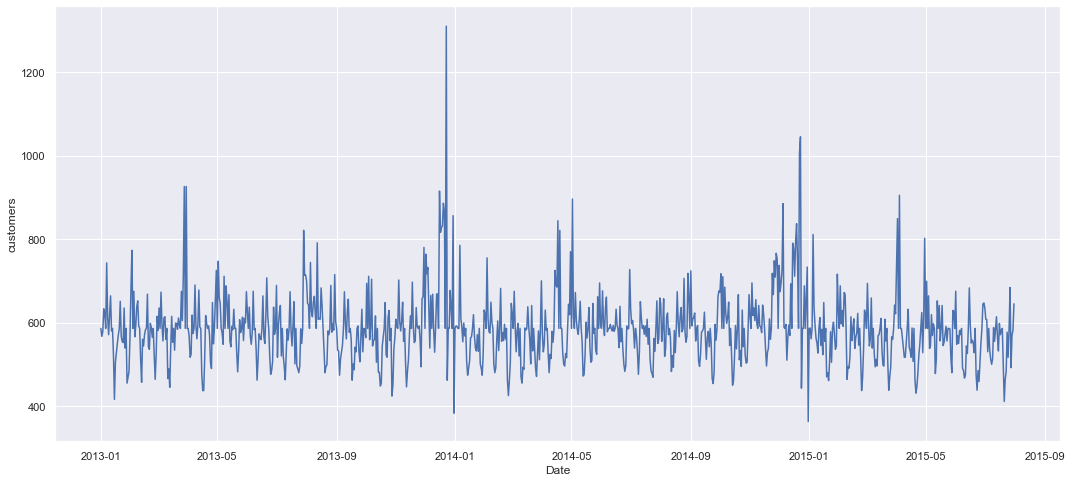

In [122]:
## plot graph
plt.xlabel('Date')
plt.ylabel('customers')
plt.plot(new_df['customers'])
plt.show()

In [123]:
new_df.head()

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast
date,,,,,,,,,,,,
2013-01-01,31,2,5862.427296,586.05102,0,0,a,1,0,8.676319,8.656665,5748.331141
2013-01-02,31,3,5122.000000,567.00000,1,0,0,1,0,8.541300,8.667179,5809.086369
2013-01-03,31,4,5623.000000,578.00000,1,0,0,1,0,8.634621,8.610906,5491.219931
2013-01-04,31,5,6140.000000,633.00000,1,0,0,1,0,8.722580,8.623358,5560.027497
2013-01-05,31,6,5607.000000,624.00000,1,0,0,0,0,8.631771,8.673436,5845.552293


**ADF test**

In [124]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(new_df['customers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

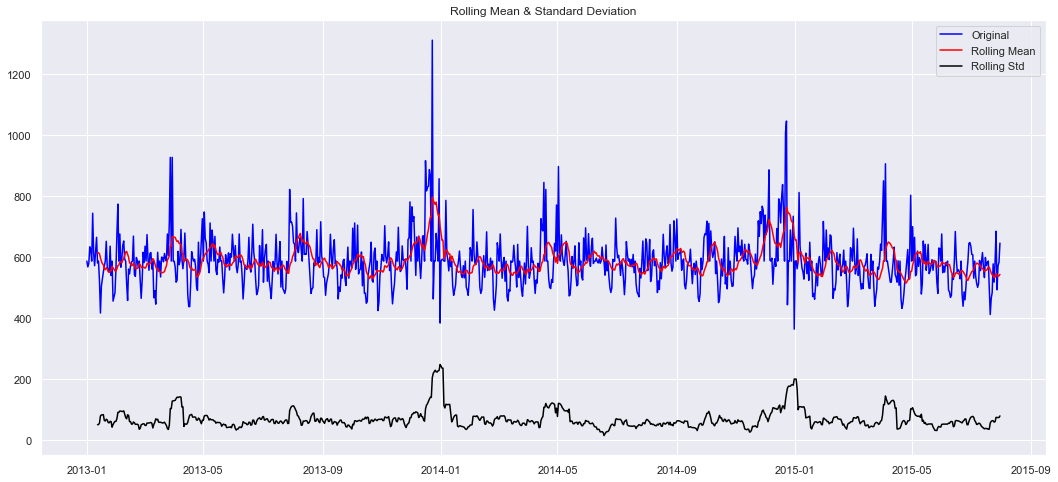

Results of Dickey Fuller Test:
Test Statistic                -6.366521e+00
p-value                        2.402381e-08
#Lags Used                     1.600000e+01
Number of Observations Used    9.250000e+02
Critical Value (1%)           -3.437439e+00
Critical Value (5%)           -2.864670e+00
Critical Value (10%)          -2.568436e+00
dtype: float64


In [125]:
test_stationarity(new_df['customers'])

- Null: Time Series is not stationary
- Alternate: Time Series is Stationary

**The p-value is less than 0.05 so The series is stationary**

In [127]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(new_df['customers'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.097017
Critical Values @ 0.05: 0.46
p-value: 0.100000


- Null: Time Series is not stationary
- Alternate: Time Series is Stationary

**The p-value is less than 0.05 so The series is non-stationary**

**Log transformation has made mean & variance constant**

In [128]:
#Log Transformation
new_df['customers_log'] = np.log(new_df['customers'])
new_df.head()

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast,customers_log
date,,,,,,,,,,,,,
2013-01-01,31,2,5862.427296,586.05102,0,0,a,1,0,8.676319,8.656665,5748.331141,6.373407
2013-01-02,31,3,5122.000000,567.00000,1,0,0,1,0,8.541300,8.667179,5809.086369,6.340359
2013-01-03,31,4,5623.000000,578.00000,1,0,0,1,0,8.634621,8.610906,5491.219931,6.359574
2013-01-04,31,5,6140.000000,633.00000,1,0,0,1,0,8.722580,8.623358,5560.027497,6.450470
2013-01-05,31,6,5607.000000,624.00000,1,0,0,0,0,8.631771,8.673436,5845.552293,6.436150


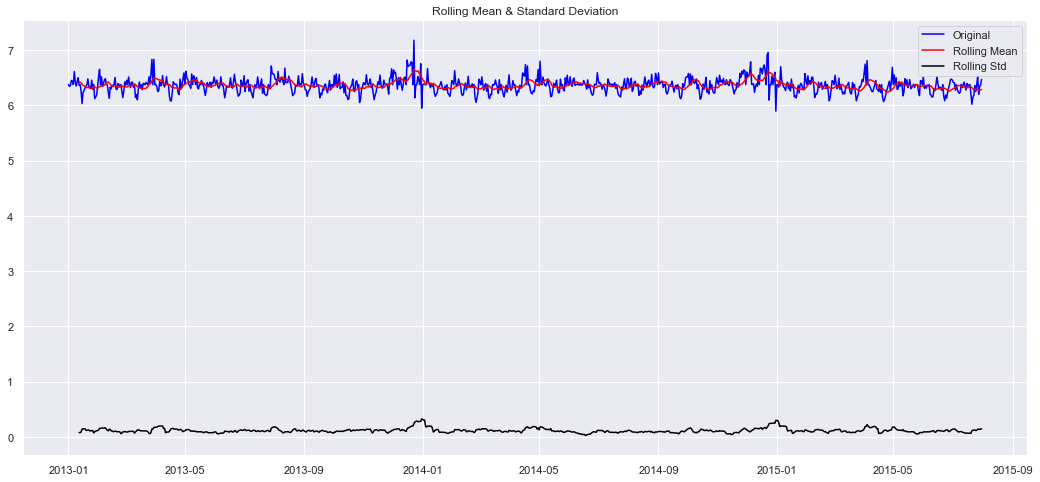

Results of Dickey Fuller Test:
Test Statistic                -6.366521e+00
p-value                        2.402381e-08
#Lags Used                     1.600000e+01
Number of Observations Used    9.250000e+02
Critical Value (1%)           -3.437439e+00
Critical Value (5%)           -2.864670e+00
Critical Value (10%)          -2.568436e+00
dtype: float64


In [129]:
test_stationarity(new_df['customers_log'])

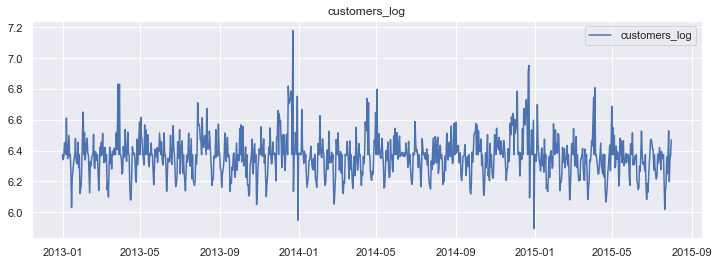

In [130]:
#plot the arima Log series
plt.figure(figsize=(12,4))
plt.plot(new_df['customers_log'],label='customers_log')
plt.legend(loc='best')
plt.title('customers_log')
plt.show()

In [131]:
#Let's check the info
new_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 942 entries, 2013-01-01 to 2015-07-31
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   store            942 non-null    int64  
 1   day_of_week      942 non-null    int64  
 2   sales            942 non-null    float64
 3   customers        942 non-null    float64
 4   open             942 non-null    int64  
 5   promo            942 non-null    int64  
 6   state_holiday    942 non-null    object 
 7   school_holiday   942 non-null    int64  
 8   promo2           942 non-null    int64  
 9   sales_log        942 non-null    float64
 10  ar_forecast_Log  942 non-null    float64
 11  arima_forecast   942 non-null    float64
 12  customers_log    942 non-null    float64
dtypes: float64(6), int64(6), object(1)
memory usage: 143.0+ KB


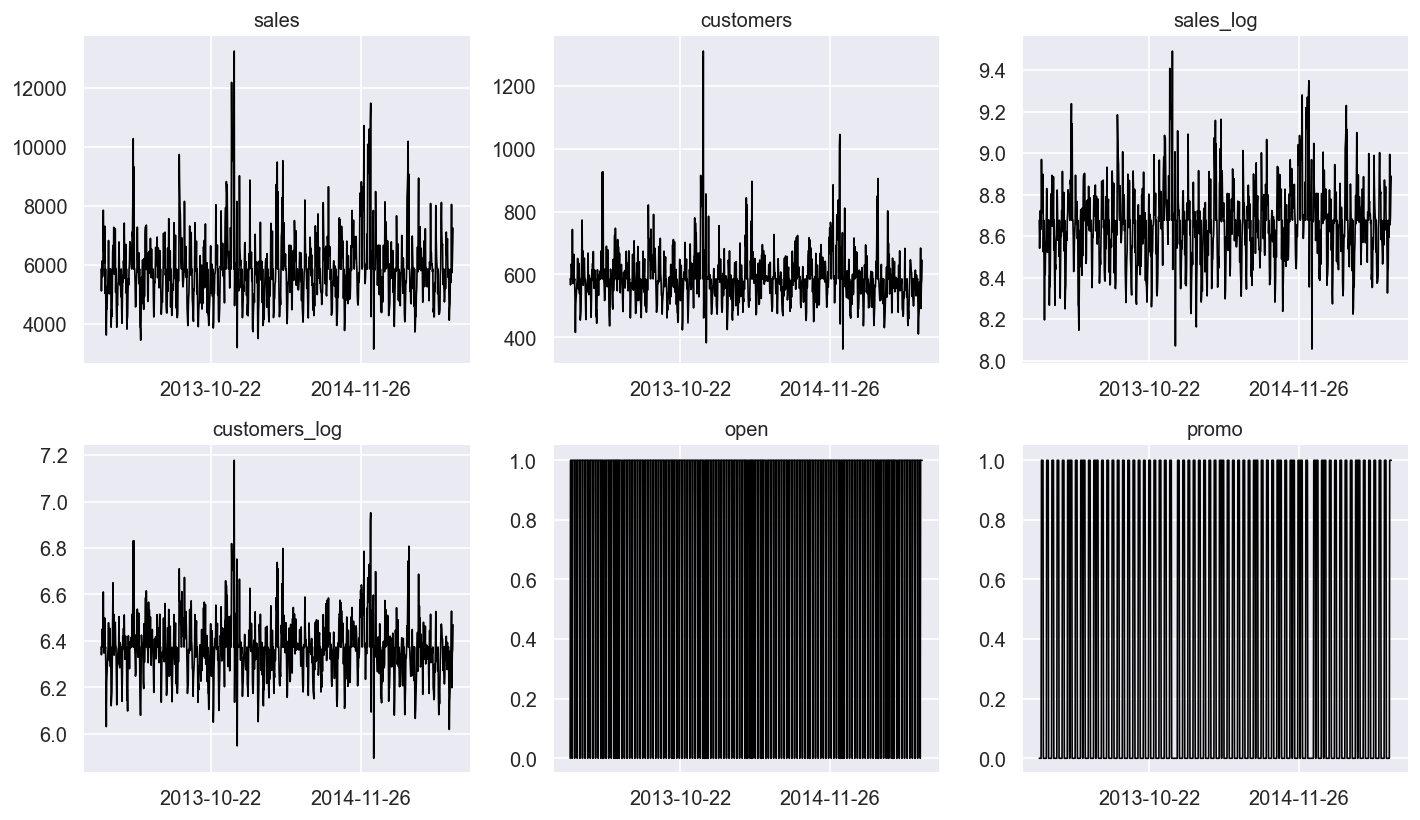

In [132]:
# Plot
ls=['sales','customers','sales_log','customers_log','open','promo','state_holiday','promo2','school_holiday']
df=new_df[ls]
fig, axes = plt.subplots(nrows=2, ncols=3, dpi=120, figsize=(12,7))
for i, ax in enumerate(axes.flatten()):
        ax.plot(df[df.columns[i]], color='black', linewidth=1)
        ax.xaxis.set_major_locator(plt.MaxNLocator(3))
        # Decorations
        ax.set_title(df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=12)

plt.tight_layout();

In [133]:
new_df.columns

Index(['store', 'day_of_week', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'promo2', 'sales_log',
       'ar_forecast_Log', 'arima_forecast', 'customers_log'],
      dtype='object')

In [134]:
new_df1=new_df[['sales_log', 'customers_log']]
new_df1

,sales_log,customers_log
date,,
2013-01-01,8.676319,6.373407
2013-01-02,8.541300,6.340359
2013-01-03,8.634621,6.359574
2013-01-04,8.722580,6.450470
2013-01-05,8.631771,6.436150
...,...,...
2015-07-27,8.993924,6.527958
2015-07-28,8.654517,6.198479
2015-07-29,8.696510,6.345636


In [135]:
#Let's create a model
model = VAR(new_df1)
for i in [1,2,3,4,5]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -9.704219594160252
BIC :  -9.673314536947167
FPE :  6.102545102097867e-05
HQIC:  -9.692438906011342 

Lag Order = 2
AIC :  -9.754021196129575
BIC :  -9.702469282562936
FPE :  5.80607317872574e-05
HQIC:  -9.734369132443405 

Lag Order = 3
AIC :  -9.776204745400246
BIC :  -9.703971074783723
FPE :  5.678693973016495e-05
HQIC:  -9.748667192644081 

Lag Order = 4
AIC :  -9.791573310026125
BIC :  -9.69862288456545
FPE :  5.592091306027979e-05
HQIC:  -9.756136114392476 

Lag Order = 5
AIC :  -9.87384667261164
BIC :  -9.760144397041474
FPE :  5.150433829032107e-05
HQIC:  -9.830495639861331 



In [136]:
x = model.select_order(maxlags=5)
x.summary()

,AIC,BIC,FPE,HQIC
0,-9.187,-9.177,0.0001023,-9.183
1,-9.702,-9.671,6.118e-05,-9.690
2,-9.751,-9.700,5.822e-05,-9.732
3,-9.776,-9.704,5.679e-05,-9.749
4,-9.793,-9.700,5.585e-05,-9.757
5,-9.874*,-9.760*,5.150e-05*,-9.830*


In [137]:
#Let's fit the model
model_fitted = model.fit()
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 15, Jan, 2022
Time:                     18:35:16
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -9.67331
Nobs:                     941.000    HQIC:                  -9.69244
Log likelihood:           1901.39    FPE:                6.10255e-05
AIC:                     -9.70422    Det(Omega_mle):     6.06382e-05
--------------------------------------------------------------------
Results for equation sales_log
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    4.453885         0.256031           17.396           0.000
L1.sales_log             0.840915         0.069655           12.073           0.000
L1.customers_log        -0.483410         0.

In [138]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

1


In [139]:
# Input data for forecasting
forecast_input = new_df1.values[-lag_order:]
forecast_input

array([[8.88848085, 6.46925032]])

In [140]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=192)
df_forecast = pd.DataFrame(fc, index=new_df.index[-192:], columns=new_df1.columns + '_2d')
df_forecast

,sales_log_2d,customers_log_2d
date,,
2015-01-21,8.801039,6.433293
2015-01-22,8.744891,6.407426
2015-01-23,8.710179,6.390735
2015-01-24,8.689058,6.380396
2015-01-25,8.676295,6.374099
...,...,...
2015-07-27,8.657009,6.364541
2015-07-28,8.657009,6.364541
2015-07-29,8.657009,6.364541


In [141]:
df_forecast['VAR_forecast_Sales'] = np.exp(df_forecast['sales_log_2d'])
df_forecast['VAR_forecast_customers'] = np.exp(df_forecast['customers_log_2d'])
df_forecast

,sales_log_2d,customers_log_2d,VAR_forecast_Sales,VAR_forecast_customers
date,,,,
2015-01-21,8.801039,6.433293,6641.143546,622.219636
2015-01-22,8.744891,6.407426,6278.527332,606.331051
2015-01-23,8.710179,6.390735,6064.326772,596.294696
2015-01-24,8.689058,6.380396,5937.584632,590.161291
2015-01-25,8.676295,6.374099,5862.284677,586.457083
...,...,...,...,...
2015-07-27,8.657009,6.364541,5750.310480,580.877949
2015-07-28,8.657009,6.364541,5750.310480,580.877949
2015-07-29,8.657009,6.364541,5750.310480,580.877949


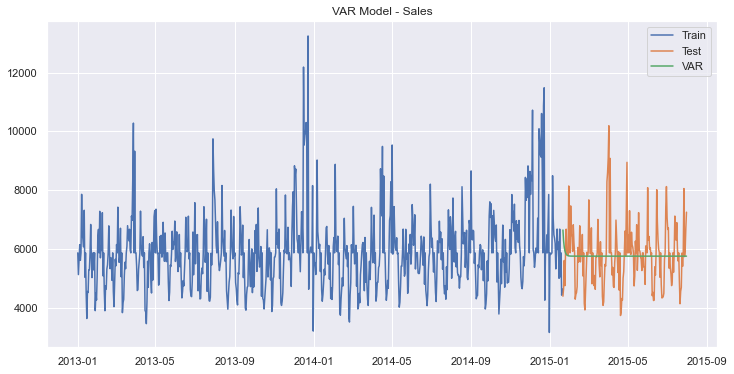

In [142]:
plt.figure(figsize=(12,6)) 
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(df_forecast['VAR_forecast_Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Sales')
plt.show()

In [143]:
train_len = 750
train1 = new_df[0:train_len] # first 890days as training set
test1 = new_df[train_len:] # last 42 days as out-of-time test set

In [144]:
train1.head()

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast,customers_log
date,,,,,,,,,,,,,
2013-01-01,31,2,5862.427296,586.05102,0,0,a,1,0,8.676319,8.656665,5748.331141,6.373407
2013-01-02,31,3,5122.000000,567.00000,1,0,0,1,0,8.541300,8.667179,5809.086369,6.340359
2013-01-03,31,4,5623.000000,578.00000,1,0,0,1,0,8.634621,8.610906,5491.219931,6.359574
2013-01-04,31,5,6140.000000,633.00000,1,0,0,1,0,8.722580,8.623358,5560.027497,6.450470
2013-01-05,31,6,5607.000000,624.00000,1,0,0,0,0,8.631771,8.673436,5845.552293,6.436150


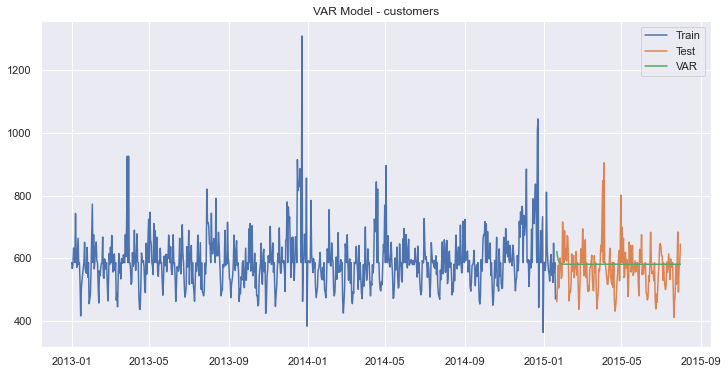

In [145]:
plt.figure(figsize=(12,6)) 
plt.plot(train1['customers'], label='Train')
plt.plot(test1['customers'], label='Test')
plt.plot(df_forecast['VAR_forecast_customers'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - customers')
plt.show()

**Model Evalution**

In [147]:
# Let's calculate the rmse and MAPE
rmse = np.sqrt(mean_squared_error(test1['sales'], df_forecast['VAR_forecast_Sales'])).round(2)
mape = np.round(np.mean(np.abs(test1['sales']-df_forecast['VAR_forecast_Sales'])/test1['sales'])*100,2)
tempResults = pd.DataFrame({'Method':['VAR'], 'RMSE': [rmse],'MAPE': [mape] })

In [148]:
tempResults

,Method,RMSE,MAPE
0,VAR,1075.4,13.44


In [149]:
results = pd.concat([Results , tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,ARIMA,804.7,10.32
0,VAR,1075.4,13.44


**Johansen-Impulse**

In [150]:
joh_model1 = coint_johansen(new_df[['sales','customers']],-1,1)

In [151]:
joh_model1

In [152]:
joh_model1.lr1

array([132.08936448,   1.78363634])

In [153]:
joh_model1.lr2

array([130.30572814,   1.78363634])

In [154]:
new_df[['sales','customers']].shape

(942, 2)

In [155]:
def joh_output(res):
    output = pd.DataFrame([res.lr2,res.lr1],
                          index=['max_eig_stat',"trace_stat"])
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')

In [156]:
joh_output(joh_model1)

   max_eig_stat  trace_stat
0    130.305728  132.089364
1      1.783636    1.783636 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 



In [157]:
from statsmodels.tsa.vector_ar.vecm import select_coint_rank

In [158]:
rank=select_coint_rank(new_df[['sales','customers']],-1,1)
print(rank.rank)

1


**Rank is one**

In [161]:
from statsmodels.tsa.stattools import coint

In [162]:
coint(new_df['sales'],new_df['customers'])#null hypothesis-There is not coint

(-3.285066238599613,
 0.0568160505695867,
 array([-3.90811644, -3.3426309 , -3.04896019]))

0.0568160505695867>.05

We can't reject the null hypothesis

**Sales and customers aren't cointegration to each other**

**VARMAX MODEL**

In [163]:
#create dymmy variables
new_df=pd.get_dummies(new_df)
new_df.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast,customers_log,state_holiday_0,state_holiday_a,state_holiday_b,state_holiday_c
date,,,,,,,,,,,,,,,,
2013-01-01,31,2,5862.427296,586.05102,0,0,1,0,8.676319,8.656665,5748.331141,6.373407,0,1,0,0
2013-01-02,31,3,5122.000000,567.00000,1,0,1,0,8.541300,8.667179,5809.086369,6.340359,1,0,0,0
2013-01-03,31,4,5623.000000,578.00000,1,0,1,0,8.634621,8.610906,5491.219931,6.359574,1,0,0,0
2013-01-04,31,5,6140.000000,633.00000,1,0,1,0,8.722580,8.623358,5560.027497,6.450470,1,0,0,0
2013-01-05,31,6,5607.000000,624.00000,1,0,0,0,8.631771,8.673436,5845.552293,6.436150,1,0,0,0


In [164]:
new_df.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast,customers_log,state_holiday_0,state_holiday_a,state_holiday_b,state_holiday_c
date,,,,,,,,,,,,,,,,
2013-01-01,31,2,5862.427296,586.05102,0,0,1,0,8.676319,8.656665,5748.331141,6.373407,0,1,0,0
2013-01-02,31,3,5122.000000,567.00000,1,0,1,0,8.541300,8.667179,5809.086369,6.340359,1,0,0,0
2013-01-03,31,4,5623.000000,578.00000,1,0,1,0,8.634621,8.610906,5491.219931,6.359574,1,0,0,0
2013-01-04,31,5,6140.000000,633.00000,1,0,1,0,8.722580,8.623358,5560.027497,6.450470,1,0,0,0
2013-01-05,31,6,5607.000000,624.00000,1,0,0,0,8.631771,8.673436,5845.552293,6.436150,1,0,0,0


In [167]:
exog = new_df[['open','promo','school_holiday','promo2','state_holiday_0','state_holiday_a','state_holiday_b','state_holiday_c']]
mod = sm.tsa.VARMAX(new_df[['sales_log', 'customers_log']], order=(1,1), trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                                 Statespace Model Results                                 
Dep. Variable:     ['sales_log', 'customers_log']   No. Observations:                  942
Model:                                VARMAX(1,1)   Log Likelihood                2119.713
Date:                            Sat, 15 Jan 2022   AIC                          -4185.426
Time:                                    18:44:35   BIC                          -4054.530
Sample:                                01-01-2013   HQIC                         -4135.532
                                     - 07-31-2015                                         
Covariance Type:                              opg                                         
Ljung-Box (L1) (Q):             1.47, 1.98   Jarque-Bera (JB):        590.44, 23.03
Prob(Q):                        0.23, 0.16   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.43, 0.94   Skew:                       0.65, 0.06
Prob(H) (two-sided):

In [168]:
train_len = 750
train = new_df[0:train_len] # first 7500days as training set
test = new_df[train_len:] 

start_index = test.index.min()
end_index = test.index.max()

In [169]:
print(start_index)
print(end_index)

2015-01-21 00:00:00
2015-07-31 00:00:00


In [170]:
test.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast,customers_log,state_holiday_0,state_holiday_a,state_holiday_b,state_holiday_c
date,,,,,,,,,,,,,,,,
2015-01-21,31,3,4386.000000,461.00000,1,0,0,0,8.386173,8.506002,4944.356012,6.133398,1,0,0,0
2015-01-22,31,4,4639.000000,506.00000,1,0,0,0,8.442254,8.483736,4835.482612,6.226537,1,0,0,0
2015-01-23,31,5,5602.000000,578.00000,1,0,0,0,8.630879,8.484281,4838.118975,6.359574,1,0,0,0
2015-01-24,31,6,4744.000000,505.00000,1,0,0,0,8.464636,8.595787,5408.825356,6.224558,1,0,0,0
2015-01-25,31,7,5862.427296,586.05102,0,0,0,0,8.676319,8.594309,5400.837686,6.373407,1,0,0,0


In [171]:
predictions = mod.fit().predict(start=start_index, end=end_index, exog=test[['open','promo','school_holiday','promo2','state_holiday_0','state_holiday_a','state_holiday_b','state_holiday_c']])

In [172]:
predictions

,sales_log,customers_log
2015-01-21,8.481795,6.262486
2015-01-22,8.465163,6.252264
2015-01-23,8.482777,6.277678
2015-01-24,8.544373,6.314094
2015-01-25,8.615967,6.323812
...,...,...
2015-07-27,8.771153,6.414322
2015-07-28,8.881873,6.461149
2015-07-29,8.780774,6.377753
2015-07-30,8.790601,6.415637


In [173]:
predictions['VARMAX_forecast_Sales'] = np.exp(predictions['sales_log'])
predictions['VARMAX_forecast_customers'] = np.exp(predictions['customers_log'])
predictions

,sales_log,customers_log,VARMAX_forecast_Sales,VARMAX_forecast_customers
2015-01-21,8.481795,6.262486,4826.105950,524.521397
2015-01-22,8.465163,6.252264,4746.501275,519.187069
2015-01-23,8.482777,6.277678,4830.845349,532.550601
2015-01-24,8.544373,6.314094,5137.762975,552.301628
2015-01-25,8.615967,6.323812,5519.085594,557.694789
...,...,...,...,...
2015-07-27,8.771153,6.414322,6445.599321,610.526881
2015-07-28,8.881873,6.461149,7200.263535,639.795738
2015-07-29,8.780774,6.377753,6507.911837,588.603506
2015-07-30,8.790601,6.415637,6572.179759,611.330126


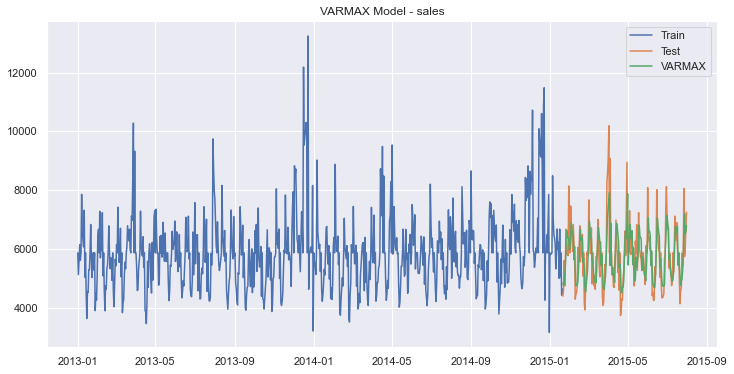

In [174]:
plt.figure(figsize=(12,6)) 
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(predictions['VARMAX_forecast_Sales'], label='VARMAX')
plt.legend(loc='best')
plt.title('VARMAX Model - sales')
plt.show()

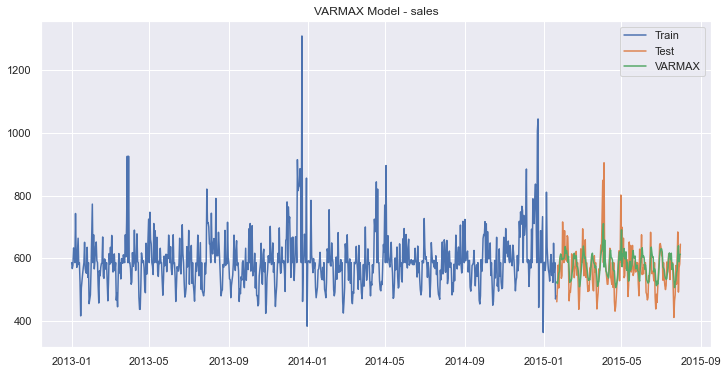

In [175]:
plt.figure(figsize=(12,6)) 
plt.plot(train['customers'], label='Train')
plt.plot(test['customers'], label='Test')
plt.plot(predictions['VARMAX_forecast_customers'], label='VARMAX')
plt.legend(loc='best')
plt.title('VARMAX Model - sales')
plt.show()

**Model Evalution**

In [176]:
# Let's calculate the rmse and MAPE
rmse = np.sqrt(mean_squared_error(test['sales'], predictions['VARMAX_forecast_Sales'])).round(2)
mape = np.round(np.mean(np.abs(test['sales']-predictions['VARMAX_forecast_Sales'])/test['sales'])*100,2)
tempResults = pd.DataFrame({'Method':['VARMAX'], 'RMSE': [rmse],'MAPE': [mape] })

In [177]:
results = pd.concat([results  , tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,ARIMA,804.70,10.32
0,VAR,1075.40,13.44
0,VARMAX,781.76,9.70


**VARMAX is the best model**

-  Is the sales data non-stationary? If so, how do you find it and correct it?

-  Is the data cointegrated? Which variables are cointegrated and how do you find them?

-  What is the impact of the number of customers on sales?

-  What is the impact of promo and promo2 variables on sales? How do you measure it?

-  **Forecast sales for the next 6 weeks? Report the accuracy of the model using MAPE**

-   Find outliers at the 99th percentile and remove them.

-   Standardize the sales and number of customers variables before modelling.

-   Determine if the data is stationary

-   If stationary then apply Vector Autoregression Model.

-   If non-stationary then specify the model in differences

-   Make sales, promo2 and any other variables you think of as dependent variables.

-   check for cointegration using the Johansen test. 

-   **Predict sales for the next 6 weeks**

# Conclusion


-   The data is stationary
-   Sales and Customers aren't cointegrated to each others
-   Sales will get increase as the number of customer will get increase.
-   promo has positive impact on sales
-   promo2 doesn't have any impact on sales